# GPR-Accelerated NEB Tutorial

This tutorial demonstrates how to use `aenet-gpr` for **GPR-accelerated Nudged Elastic Band (NEB) calculations**, which accelerates the demanding NEB calculations for transition state search.

GPR-NEB references:
- [J. A. Garrido Torres, P. C. Jennings, M. H. Hansen, J. R. Boes, and T. Bligaard, “Low-Scaling Algorithm for Nudged Elastic Band Calculations Using a Surrogate Machine Learning Model”, *Phys. Rev. Lett.* 122, 156001 (2019).](https://doi.org/10.1103/PhysRevLett.122.156001)
- [O. Koistinen, F. B. Dagbjartsdóttir, V. Ásgeirsson, A. Vehtari, and H. Jónsson, "Nudged elastic band calculations accelerated with Gaussian process regression", *J. Chem. Phys.* 147, 152720 (2017)](https://doi.org/10.1063/1.4986787)

In this example, we use a simple **EMT potential** as the reference calculator. However, the same framework is fully compatible with any [ASE-compatible DFT calculators](https://wiki.fysik.dtu.dk/ase/ase/calculators/calculators.html).

Replacing the reference with a DFT calculator allows GPR-NEB to reproduce **transition states** on a DFT-level potential energy surface (PES), with **significantly fewer expensive DFT evaluations** than standard NEB.

# ===== Preparation =====

## Reference calculator: Effective Medium Theory (EMT)

In [1]:
try:
    import ase.io
    print("successfully imported ase")
except ImportError:
    !! pip install ase --user --upgrade
    print("completed installing ASE")

successfully imported ase


In [2]:
from ase.build import add_adsorbate, fcc100
from ase.calculators.emt import EMT
from ase.constraints import FixAtoms
from ase.optimize import QuasiNewton, BFGS, MDMin, FIRE

from IPython.display import Image
import copy
import numpy as np

In [3]:
# 2x2-Al(001) surface with 3 layers and an
# Au atom adsorbed in a hollow site:
slab = fcc100('Al', size=(2, 2, 3))
add_adsorbate(slab, 'Au', 1.7, 'hollow')
slab.center(axis=2, vacuum=4.0)

In [4]:
# Fix second and third layers:
mask = [atom.tag > 1 for atom in slab]
# print(mask)
slab.set_constraint(FixAtoms(mask=mask))

In [5]:
# Use EMT potential:
slab.calc = EMT()

In [6]:
# Initial state:
qn = BFGS(slab, trajectory='initial.traj')
qn.run(fmax=0.05)

      Step     Time          Energy          fmax
BFGS:    0 15:51:10        3.323870        0.246170
BFGS:    1 15:51:10        3.321365        0.203512
BFGS:    2 15:51:10        3.314740        0.020557


True

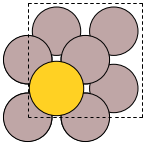

In [7]:
import ase


atoms = ase.io.read('initial.traj')
ase.io.write('initial.png', atoms)
Image("initial.png")

In [8]:
# Final state:
slab[-1].x += slab.get_cell()[0, 0] / 2
qn = BFGS(slab, trajectory='final.traj')
qn.run(fmax=0.05)

      Step     Time          Energy          fmax
BFGS:    0 15:51:11        3.320046        0.123468
BFGS:    1 15:51:11        3.319145        0.111073
BFGS:    2 15:51:11        3.315607        0.074162
BFGS:    3 15:51:11        3.315469        0.075507
BFGS:    4 15:51:11        3.314645        0.052638
BFGS:    5 15:51:11        3.314491        0.027698


True

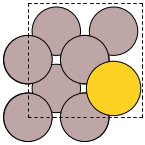

In [9]:
atoms = ase.io.read('final.traj')
ase.io.write('final.png', atoms)
Image("final.png")

# ===== Conventional NEB =====

In [10]:
from ase.calculators.emt import EMT
from ase.constraints import FixAtoms
from ase.io import read
from ase.mep import NEB

In [11]:
initial = read('initial.traj')
final = read('final.traj')

In [12]:
constraint = FixAtoms(mask=[atom.tag > 1 for atom in initial])

In [13]:
images = [initial]
for i in range(5):
    image = initial.copy()
    image.calc = EMT()
    image.set_constraint(constraint)
    images.append(image)

images.append(final)

In [14]:
neb = NEB(images)
neb.interpolate()
qn = FIRE(neb, trajectory='neb.traj')
qn.run(fmax=0.05)

      Step     Time          Energy          fmax
FIRE:    0 15:51:16        4.254555        3.670245
FIRE:    1 15:51:16        4.024620        2.636978
FIRE:    2 15:51:16        3.790869        1.233507
FIRE:    3 15:51:16        3.712369        0.284014
FIRE:    4 15:51:16        3.765949        0.738334
FIRE:    5 15:51:16        3.762147        0.718966
FIRE:    6 15:51:16        3.754943        0.680504
FIRE:    7 15:51:16        3.745105        0.623515
FIRE:    8 15:51:16        3.733711        0.548896
FIRE:    9 15:51:16        3.722050        0.457986
FIRE:   10 15:51:16        3.711497        0.352824
FIRE:   11 15:51:16        3.703339        0.236916
FIRE:   12 15:51:16        3.698253        0.166643
FIRE:   13 15:51:16        3.697729        0.195898
FIRE:   14 15:51:17        3.701253        0.350820
FIRE:   15 15:51:17        3.701012        0.345572
FIRE:   16 15:51:17        3.700548        0.335197
FIRE:   17 15:51:17        3.699887        0.319936
FIRE:   18 15:

True

# Total reference calculations = NEB steps $\times$ number of moving images = 33 $\times$ 5 = 165

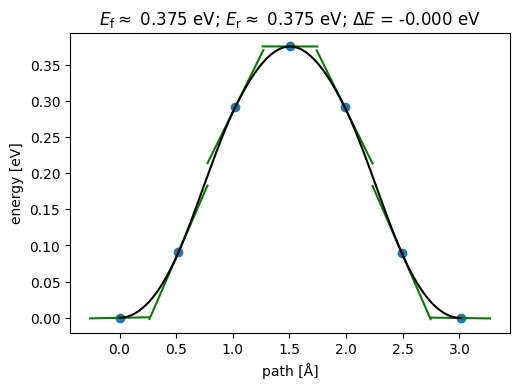

In [15]:
import matplotlib.pyplot as plt

from ase.io import read
from ase.mep import NEBTools

images = read('neb.traj@-7:')

nebtools = NEBTools(images)

# Create a figure with custom parameters.
fig = plt.figure(figsize=(5.5, 4.0))
ax = fig.add_axes((0.15, 0.15, 0.8, 0.75))
nebtools.plot_band(ax)
fig.savefig('diffusion-barrier.png')

# ===== aenet-GPR accelerated NEB =====

### Reference calculator: Effective Medium Theory (EMT)
### Surrogate calculator: aenet-gpr (GPR)

In [16]:
try:
    import torch
    print("successfully imported torch")
    print(torch.__version__)
except ImportError:
    !! pip install torch torchvision torchaudio --user --index-url https://download.pytorch.org/whl/cpu
    print("completed installing torch")

successfully imported torch
2.6.0+cu124


In [17]:
!! pip install aenet-gpr --user --upgrade
print("completed installing aenet-gpr")

! pip show aenet-gpr

completed installing aenet-gpr
Name: aenet-gpr
Version: 1.8.0
Summary: Atomistic simulation tools based on Gaussian Processes Regression
Home-page: https://github.com/atomisticnet/aenet-gpr
Author: In Won Yeu
Author-email: iy2185@columbia.edu
License: MPL-2.0
Location: /data/home/iy2185/.local/lib/python3.12/site-packages
Requires: ase, dscribe
Required-by: 


In [18]:
from aenet_gpr.tool.aidneb import AIDNEB
from aenet_gpr.inout.input_parameter import InputParameters

In [28]:
neb_F_max = 0.05  # cretirian of the force for the convergence.
neb_interpol = "idpp"  # "linear", "idpp", path to trajectory file
neb_n_images = 7  # total images including initial and final
use_mic = False

In [29]:
initial = read('initial.traj')
final = read('final.traj')

In [30]:
calc = EMT()

In [36]:
input_param = InputParameters()

neb = AIDNEB(start=initial,
             end=final,
             interpolation=neb_interpol,
             n_images=neb_n_images,
             mic=use_mic,
             calculator=copy.deepcopy(calc),
             use_previous_observations=True,
             input_param=input_param)

d_start_end:  2.864235082465442
spring_constant:  0.1


In [37]:
neb.run(fmax=neb_F_max, unc_convergence=0.05, dt=0.05, ml_steps=150)

Training data size:  3
Descriptor:  cartesian coordinates
GPR model hyperparameters:  {'kerneltype': 'sqexp', 'scale': tensor(0.4000, dtype=torch.float64), 'weight': tensor(0.1543, dtype=torch.float64), 'noise': tensor(1.0000e-06, dtype=torch.float64), 'noisefactor': tensor(0.5000, dtype=torch.float64), 'prior': tensor(3.5489, dtype=torch.float64)}
      Step     Time          Energy          fmax
FIRE:    0 16:02:59        3.985101        2.657923
FIRE:    1 16:03:00        3.975044        2.666849
FIRE:    2 16:03:02        3.956470        2.670833
FIRE:    3 16:03:03        3.927898        2.642313
FIRE:    4 16:03:04        3.888739        2.542422
FIRE:    5 16:03:05        3.838695        2.329186
FIRE:    6 16:03:07        3.778206        1.996308
FIRE:    7 16:03:08        3.709055        1.547656
FIRE:    8 16:03:09        3.626966        1.154966
FIRE:    9 16:03:10        3.603133        0.877951
FIRE:   10 16:03:12        3.598571        0.478328
FIRE:   11 16:03:13        

# Total reference calculations = Training data size $-$ initial and final images = 12

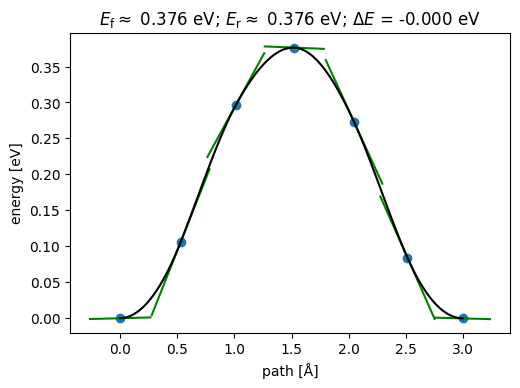

In [38]:
images = read('AIDNEB.traj@-7:')

nebtools = NEBTools(images)

# Create a figure with custom parameters.
fig = plt.figure(figsize=(5.5, 4.0))
ax = fig.add_axes((0.15, 0.15, 0.8, 0.75))
nebtools.plot_band(ax)
fig.savefig('diffusion-barrier.png')